In [2]:
from typing import Callable

import numpy as np
from matplotlib import pyplot as plt
from tabulate import tabulate

#INCREASE DEFAULT JUPYTER NOTEBOOK WIDTH TO SEE TABLES
#from IPython.core.display import display, HTML
#display(HTML("<style>.container {width: 70% !important;}</style>"))

In [3]:
def search(X: np.ndarray, target: float, tolerance: float = 1e-4) -> int:
    """Returns position to which target should be appended, assuming X is sorted."""
    left = 0 
    right = len(X) - 1
    index = 0 
    while left < right: 
        index = (left + right) // 2 
        if abs(X[index] - target) <= tolerance: 
            return index 
        else: 
            if X[index] < target:
                left = index + 1 
            else: 
                right = index 
    return index

In [4]:
def interLinear(X: np.ndarray, Y: np.ndarray, x: float, tolerance: float = 1e-4) -> float:
    if x < X[0] or x > X[-1]:
        raise ValueError('Value of `x` must be greater or equal than the first element in X and less than the last element.')
    if len(X) != len(Y):
        raise ValueError('X and Y arrays must have the same length.')
    
    index = search(X, x, tolerance)
    left_x = X[index]
    right_x = X[index+1]
    left_value = Y[index]
    right_value = Y[index+1]

    a = np.float32((right_value - left_value) / (right_x - left_x))
    b = np.float32(left_value - a*left_x)
    
    return np.float32(a*x + b)
    

In [5]:
X = [1, 2, 3, 4, 5, 6]
Y = [-1, -2, -3, -4, -5, -6]


interLinear(X, Y, 4.5)

-4.5

In [6]:
def interLagrange(X: np.ndarray, Y: np.ndarray, x: float) -> float:
    if x < X[0] or x > X[-1]:
        raise ValueError('Value of `x` must be greater or equal than the first element in X and less than the last element.')
    if len(X) != len(Y):
        raise ValueError('X and Y arrays must have the same length.')

    N = X.shape[0]
    divided_tmp = x - np.ones((N, N)) * X
    np.fill_diagonal(divided_tmp, 1)
    divided = np.apply_along_axis(np.multiply.reduce, 1, divided_tmp)

    divider_tmp = np.ones((N, N)) * -X
    divider_tmp = np.apply_along_axis(lambda col: col + X, 0, divider_tmp)
    np.fill_diagonal(divider_tmp, 1)
    divider = np.apply_along_axis(np.multiply.reduce, 1, divider_tmp)
    
    return np.sum(divided / divider * Y)


In [7]:
def interSpline(X: np.ndarray, Y: np.ndarray, x: float) -> float:
    if x < X[0] or x > X[-1]:
        raise ValueError('Value of `x` must be greater or equal than the first element in X and less than the last element.')
    if len(X) != len(Y):
        raise ValueError('X and Y arrays must have the same length.')

    N = X.shape[0] - 1
    
    h = X[1:N+1] - X[:N]
    alfa = np.zeros(N)
    alfa[1:] = 3 * (Y[2:] - Y[1:-1]) / h[1:] - 3 * (Y[1:-1] - Y[:-2]) / h[:-1]
    
    l = np.ones_like(X)
    m = np.zeros(N)
    z = np.zeros_like(X)
    
    for i in range(1, N):
        l[i] = 2 * (X[i+1] - X[i-1]) - h[i-1] * m[i-1]
        m[i] = h[i] / l[i]
        z[i] = (alfa[i] - h[i-1] * z[i-1]) / l[i]
    
    a = Y[:]
    
    c = np.empty_like(X)
    b = np.empty(N)
    d = np.empty(N)

    for i in reversed(range(0, N)):
        c[i] = z[i] - m[i] * c[i+1]
        b[i] = (a[i+1] - a[i]) / h[i] - h[i] * (c[i+1] + 2 * c[i]) / 3
        d[i] = (c[i+1] - c[i]) / 3 / h[i]
    
    # return a, b, c, d
    i = np.argmax(X > x) - 1
    
    diff = x - X[i]
    return a[i] + diff * (b[i] + diff * (c[i] + diff * d[i]))

    
    return res

In [8]:
def examine_function(f: Callable[[float], float], X: np.ndarray, Y: np.ndarray, xs: np.ndarray, interpolation_input_x_shrink: int = 1) -> None:
    ys_linear = []
    ys_lagrange = []
    ys_spline = []

    if interpolation_input_x_shrink > 1:
        shrinked_X = np.linspace(X[0], X[-1], X.shape[0] // interpolation_input_x_shrink, endpoint=True)
        shrinked_Y = f(shrinked_X)
    else:
        shrinked_X = X
        shrinked_Y = Y

    for x in xs:
        ys_linear.append(interLinear(shrinked_X, shrinked_Y, x))
        ys_lagrange.append(interLagrange(shrinked_X, shrinked_Y, x))
        ys_spline.append(interSpline(shrinked_X, shrinked_Y, x))

    fig = plt.figure(figsize=(14, 7))
    plt.plot(X, Y, 'o-k')
    plt.scatter(xs, ys_linear, marker='1', s=125, color='blue', label='Interpolated points using linear interpolation', linewidths=3)
    plt.scatter(xs, ys_lagrange, marker='x', s=125, color='red', label='Interpolated points using Lagrange interpolation', linewidths=3)
    plt.scatter(xs, ys_spline, marker='d', s=125, color='green', label='Interpolated points using spline interpolation', linewidths=3)
    plt.legend()
    plt.show()

    true_values = f(xs)
    linear_error_perc = (true_values - ys_linear) / true_values * 100
    lagrange_error_perc = (true_values - ys_lagrange) / true_values * 100
    spline_error_perc = (true_values - ys_spline) / true_values * 100

    print(tabulate(
        list(zip(true_values, ys_linear, linear_error_perc, ys_lagrange, lagrange_error_perc, ys_spline, spline_error_perc)),
        headers = ['true value', 'linear interpolation', 'linear error (%)', 'lagrange interpolation',
                   'lagrange error (%)', 'spline interpolation', 'spline error (%)'],
        tablefmt='fancy_grid'#, floatfmt=".6f
    ))


## Zadanie 1

Wyznacz metodą interpolacji liniowej, interpolacji wielomianowej oraz metodą funkcji sklejanych rzędu 3 wartość następujących funkcji:

a) $f(x) = cos(x)$ w obszarze $ 0 \le x \le 4 \pi$ dzieląc obszar na 40 równoodległych węzłów, dla x = 0.5, 1, 5, 10

b) $f(x) = 2 e^{x+1} $ w obszarze $ 0 \le x \le 10$ dzieląc obszar na 50 równoodległych węzłów, dla x = 0.45, 1.13, 3.356, 9.31

Oszacuj błąd interpolowanej wartości. Zmniejsz dwókrotnie liczbę punktów podziału i oszacuj ponownie błąd interpolacji. Czy w wypadku tych funkcji możemy stosować metodę interpolacji liniowej? (proszę uwzględnić liczbę punktów podziału).

In [9]:
num_points = 40
f = np.cos
X = np.linspace(0, 4*np.pi, num_points, endpoint=True)
Y = f(X)
xs = [0.5, 1, 5, 10]

num_points2 = 50
@np.vectorize
def f2(x: float) -> float:
    return 2 * np.e ** (x+1)
X2 = np.linspace(0, 10, num_points2, endpoint=True)
Y2 = f2(X2)
xs2 = [0.45, 1.13, 3.356, 9.31]


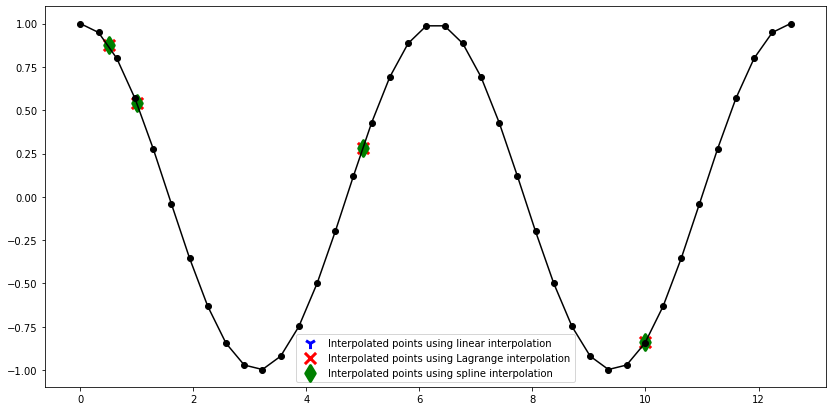

╒══════════════╤════════════════════════╤════════════════════╤══════════════════════════╤══════════════════════╤════════════════════════╤════════════════════╕
│   true value │   linear interpolation │   linear error (%) │   lagrange interpolation │   lagrange error (%) │   spline interpolation │   spline error (%) │
╞══════════════╪════════════════════════╪════════════════════╪══════════════════════════╪══════════════════════╪════════════════════════╪════════════════════╡
│     0.877583 │               0.866272 │           1.28878  │                 0.877583 │         -1.89456e-07 │               0.878752 │       -0.133211    │
├──────────────┼────────────────────────┼────────────────────┼──────────────────────────┼──────────────────────┼────────────────────────┼────────────────────┤
│     0.540302 │               0.538059 │           0.415129 │                 0.540302 │         -5.35214e-09 │               0.540352 │       -0.00912396  │
├──────────────┼────────────────────────┼─────

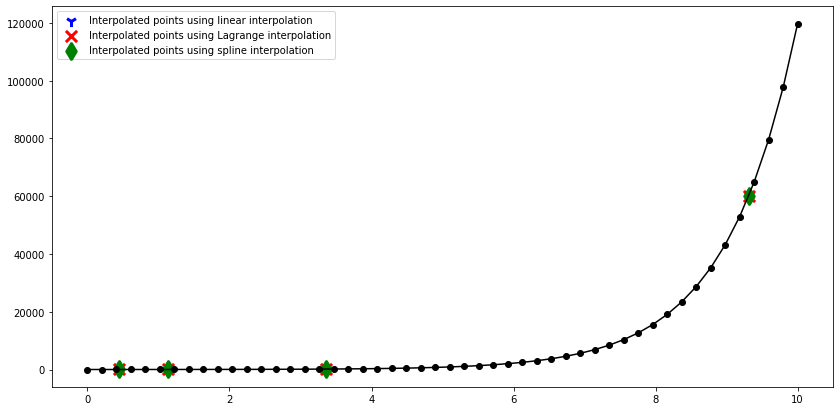

╒══════════════╤════════════════════════╤════════════════════╤══════════════════════════╤══════════════════════╤════════════════════════╤════════════════════╕
│   true value │   linear interpolation │   linear error (%) │   lagrange interpolation │   lagrange error (%) │   spline interpolation │   spline error (%) │
╞══════════════╪════════════════════════╪════════════════════╪══════════════════════════╪══════════════════════╪════════════════════════╪════════════════════╡
│      8.52623 │                8.55638 │          -0.353629 │                  8.52631 │         -0.000993247 │                8.52686 │       -0.00737954  │
├──────────────┼────────────────────────┼────────────────────┼──────────────────────────┼──────────────────────┼────────────────────────┼────────────────────┤
│     16.8297  │               16.9165  │          -0.515611 │                 16.8297  │         -8.84684e-07 │               16.8296  │        0.000516556 │
├──────────────┼────────────────────────┼─────

In [10]:
examine_function(f, X, Y, xs, 1)
examine_function(f2, X2, Y2, xs2, 1)

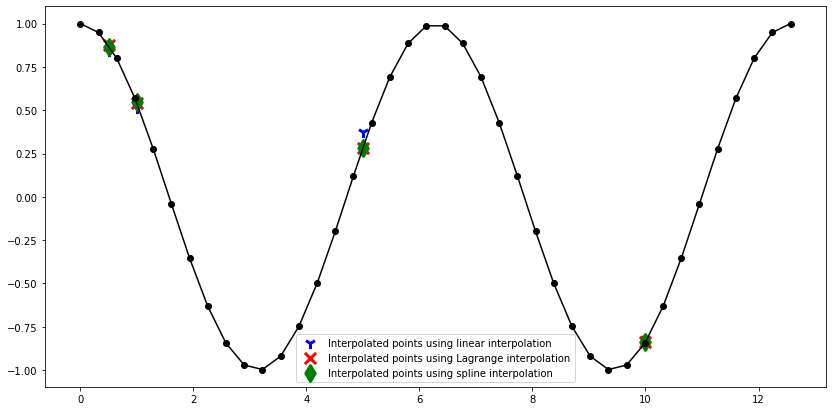

╒══════════════╤════════════════════════╤════════════════════╤══════════════════════════╤══════════════════════╤════════════════════════╤════════════════════╕
│   true value │   linear interpolation │   linear error (%) │   lagrange interpolation │   lagrange error (%) │   spline interpolation │   spline error (%) │
╞══════════════╪════════════════════════╪════════════════════╪══════════════════════════╪══════════════════════╪════════════════════════╪════════════════════╡
│     0.877583 │               0.840593 │            4.21492 │                 0.877583 │         -2.16107e-05 │               0.86648  │          1.26509   │
├──────────────┼────────────────────────┼────────────────────┼──────────────────────────┼──────────────────────┼────────────────────────┼────────────────────┤
│     0.540302 │               0.510804 │            5.45953 │                 0.540302 │          8.25663e-06 │               0.545477 │         -0.957787  │
├──────────────┼────────────────────────┼─────

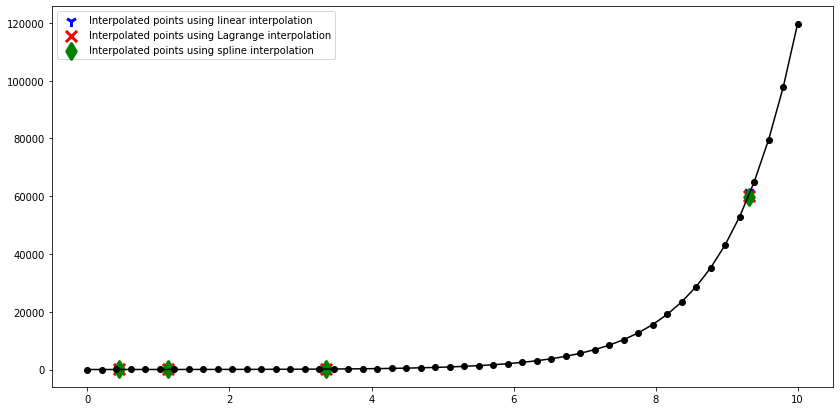

╒══════════════╤════════════════════════╤════════════════════╤══════════════════════════╤══════════════════════╤════════════════════════╤════════════════════╕
│   true value │   linear interpolation │   linear error (%) │   lagrange interpolation │   lagrange error (%) │   spline interpolation │   spline error (%) │
╞══════════════╪════════════════════════╪════════════════════╪══════════════════════════╪══════════════════════╪════════════════════════╪════════════════════╡
│      8.52623 │                6.56062 │          23.0537   │                  8.52623 │          4.17003e-09 │                8.52114 │        0.0596505   │
├──────────────┼────────────────────────┼────────────────────┼──────────────────────────┼──────────────────────┼────────────────────────┼────────────────────┤
│     16.8297  │               17.1132  │          -1.68457  │                 16.8297  │         -1.05295e-10 │               16.8309  │       -0.00713744  │
├──────────────┼────────────────────────┼─────

In [11]:
# decreasing number of points for interpolation two times
examine_function(f, X, Y, xs, 2)
examine_function(f2, X2, Y2, xs2, 2)

## Zadanie2

Zmodyfikuj punkty podziału w zadaniu 1 b) tak, by funkcja $f(x) = 2 e^{x+1} $ była zdefiniowana przez punkty na początku i końcu przedziału oraz 48 losowo wybranych punktów w przedziale. Jak wpływa nierówna odległość między interpolowanymi punktami na dokładność oszacowania?

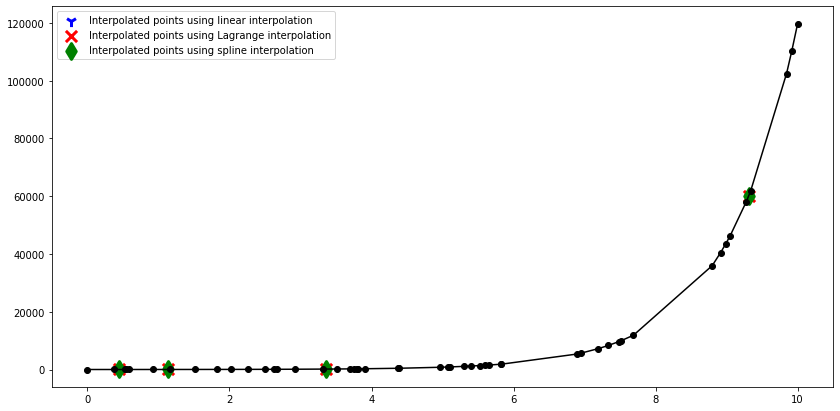

╒══════════════╤════════════════════════╤════════════════════╤══════════════════════════╤══════════════════════╤════════════════════════╤════════════════════╕
│   true value │   linear interpolation │   linear error (%) │   lagrange interpolation │   lagrange error (%) │   spline interpolation │   spline error (%) │
╞══════════════╪════════════════════════╪════════════════════╪══════════════════════════╪══════════════════════╪════════════════════════╪════════════════════╡
│      8.52623 │                8.49622 │          0.35201   │                   8.6448 │          -1.39068    │                8.52462 │        0.0189065   │
├──────────────┼────────────────────────┼────────────────────┼──────────────────────────┼──────────────────────┼────────────────────────┼────────────────────┤
│     16.8297  │               16.8894  │         -0.354691  │                  16.8276 │           0.0129702  │               16.8299  │       -0.000726977 │
├──────────────┼────────────────────────┼─────

In [12]:
X2 = np.r_[[0], np.sort(np.random.uniform(0, 10, 48)), [10]]
Y2 = f2(X2)
xs2 = [0.45, 1.13, 3.356, 9.31]
examine_function(f2, X2, Y2, xs2)


## Zadanie 3

Metodą interpolacji funkcji sklejanych interpoluj dane zawarte w plikach X.dat i Y.dat w punktach $x = 0.25, x = 1, x =5, x= 9.95 $. Narysuj oryginalne dane oraz interpolowane punkty na jednym wykresie. Dane do weryfikacji wyniku: $f(0.25) =5.136101666750966 , f(1.0)=2.718281828459045 , f(5.0) = 29.682631820515315, f(9.95) = 2105.750993143581$

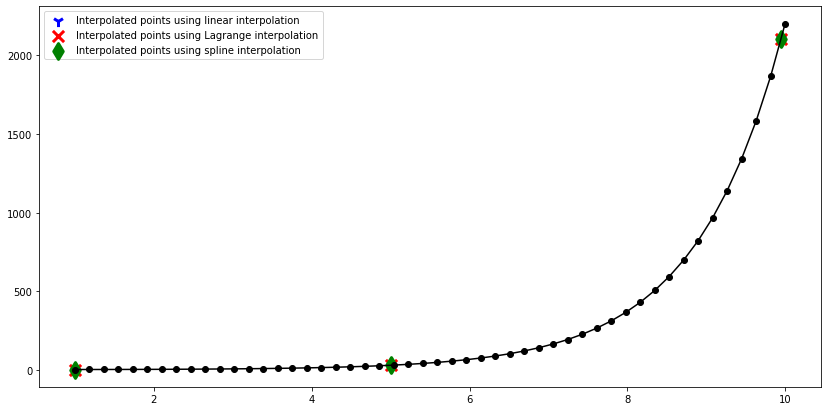

╒══════════════╤════════════════════════╤════════════════════╤══════════════════════════╤══════════════════════╤════════════════════════╤════════════════════╕
│   true value │   linear interpolation │   linear error (%) │   lagrange interpolation │   lagrange error (%) │   spline interpolation │   spline error (%) │
╞══════════════╪════════════════════════╪════════════════════╪══════════════════════════╪══════════════════════╪════════════════════════╪════════════════════╡
│      2.71828 │                2.71828 │        3.03679e-06 │                  2.71828 │          0           │                2.71828 │        0           │
├──────────────┼────────────────────────┼────────────────────┼──────────────────────────┼──────────────────────┼────────────────────────┼────────────────────┤
│     29.6826  │               29.5827  │        0.336807    │                 29.6826  │         -1.43628e-13 │               29.6826  │        6.61191e-05 │
├──────────────┼────────────────────────┼─────

In [13]:
X_data = []
with open('X.dat', 'r') as X_data_file:
    for line in X_data_file:
        X_data.append(float(line.strip()))
X_data = np.array(X_data)
Y_data = []
with open('Y.dat', 'r') as Y_data_file:
    for line in Y_data_file:
        Y_data.append(float(line.strip()))
Y_data = np.array(Y_data, dtype=float)

@np.vectorize
def func(x: float) -> float:
    if abs(x-0.25) <= 1e-3:
        return 5.136101666750966
    elif abs(x-1) <= 1e-3:
        return 2.718281828459045
    elif abs(x-5) <= 1e-3:
        return 29.682631820515315
    elif abs(x-9.95) <= 1e-3:
        return 2105.750993143581
    else:
        raise ValueError(f'Cannot return function value for x={x}')

xs = np.array([1, 5, 9.95])
ys = np.array([interSpline(X_data, Y_data, x) for x in xs])
examine_function(func, X_data, Y_data, xs)


## Zadanie 4 (Dodatkowe)

Przygotuj funkcję, która wyznaczy współczynniki wielomianu interpolującego metodą eliminacji Gaussa.

In [24]:
def solve_equation_system(A: np.ndarray) -> np.ndarray:
    """Solves linear equation system using Gauss elimination method.

    Parameters
    ----------
    A : np.ndarray
        Input array with the last column containing Y values.

    Returns
    -------
    np.ndarray
        Solution.

    """
    A_copy = A.copy()
    row, col = 0, 0
    rows, cols, *_ = A.shape
    while col < cols and row < rows:
        zeros = np.sum(A_copy[row: rows, col] == 0)
        if zeros == rows - row:
            col += 1
        else:
            for i in range(row + 1, rows):
                if A_copy[i, col] != 0:
                    tmp = A_copy[i].copy()
                    A_copy[i] = A_copy[row]
                    A_copy[row] = tmp
                    break
            A_copy[row, :] /= A_copy[row, col]
            for i in range(0, rows):
                if i != row:
                    A_copy[i, :] -= A_copy[row, :] * A_copy[i, col]
            col += 1
            row += 1
    return A_copy

def calculate_interpolation_coefs(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    N, *_ = X.shape
    matrix = np.c_[
        np.ones((N, N)) * X.reshape(-1, 1) ** np.arange(N),
        Y
    ]
    return solve_equation_system(matrix)[:, -1]


X = np.arange(4)
Y = -5.5 + 3.33 * X - 66.6 * X ** 2 + 17 * X ** 3

calculate_interpolation_coefs(X, Y)

array([ -5.5 ,   3.33, -66.6 ,  17.  ])